In [1]:
import os
os.chdir("../")
# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

from config import *
from data import *
from train import *
from eval import *
from generation import *
from vital2d import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [7]:
# (customize) configs
overwrite = True
model_name = 'tmp' 
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'description_succ_unc',
    y_levels = ['Many flat lines.', 'Few flat lines.'],
    y_pred_levels = ['Many flat lines.', 'Few flat lines.'],
    # txt2ts
    txt2ts_y_cols = ['description_succ_unc'],
    
    
    # Data settings
    text_col = 'ts_description', #'ts_description',
    downsample = True,
    downsample_size = 500,
    downsample_levels = ['Many flat lines.', 'Few flat lines.'],
    custom_target_cols = ['description_succ_unc', 'description_succ_inc', 'description_histogram'] + ['label']*5, # 
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = False,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 200,
    alpha = 1/10,
    num_saves = 20,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()


# Data

In [3]:
# run preprocess.py to ready the data
with open('run_preprocess.py', 'r') as file:
    exec(file.read())



Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.7s
[Parallel(n_jobs=9)]: Done 1901 tasks      | elapsed:    5.1s
[Parallel(n_jobs=9)]: Done 62253 tasks      | elapsed:   14.4s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   14.8s finished


replace 'text' with:  ts_description
text
Moderate variability. A few outliers. Moderate amount of consecutive increases. Moderate flat lines. No events.    4966
Moderate variability. A few outliers. Moderate amount of consecutive increases. Few flat lines. No events.         4573
High variability. A few outliers. Moderate amount of consecutive increases. Few flat lines. No events.             3748
Higher than the normal range. Low variability. Low amount of consecutive increases. Many flat lines. No events.    3658
High variability. A few outliers. High amount of consecutive increases. Few flat lines. No events.                 3578
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.5s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    8.8s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    8.8s finished


replace 'text' with:  ts_description
text
Higher than the normal range. Low variability. Low amount of consecutive increases. Many flat lines. No events.              5034
Higher than the normal range. Moderate variability. Moderate amount of consecutive increases. Many flat lines. No events.    3896
Moderate variability. A few outliers. Moderate amount of consecutive increases. Many flat lines. No events.                  3313
Moderate variability. Moderate amount of consecutive increases. Many flat lines. No events.                                  2892
Moderate variability. A few outliers. Moderate amount of consecutive increases. Moderate flat lines. No events.              2591
Name: count, dtype: int64
After downsampling:
description_succ_unc
Many flat lines.    500
Few flat lines.     500
Name: count, dtype: int64
After downsampling:
description_succ_unc
Many flat lines.    500
Few flat lines.     500
Name: count, dtype: int64


final distribution of text prediction
description_

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Model (customizable)

In [4]:
# customize encoder and decoder here. 
ts_encoder = CNNEncoder(ts_dim=300, output_dim=config_dict['embedded_dim'], num_channels=[4], kernel_size=50, dropout=0)
ts_decoder = None
text_encoder_type = 'cnn'
# overwrite = False
with open('run_model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                        Param #
VITAL                                         1
├─TSVAEEncoder: 1-1                           --
│    └─LocalNorm: 2-1                         --
│    └─CNNEncoder: 2-2                        --
│    │    └─Sequential: 3-1                   307,924
│    └─Linear: 2-3                            262,656
│    └─Linear: 2-4                            262,656
├─TextEncoder: 1-2                            --
│    └─TextEncoderCNN: 2-5                    --
│    │    └─Sequential: 3-2                   36,672
├─TSVAEDecoder: 1-3                           --
│    └─Sequential: 2-6                        --
│    │    └─Linear: 3-3                       131,328
│    │    └─LeakyReLU: 3-4                    --
│    │    └─Linear: 3-5                       65,792
│    │    └─LeakyReLU: 3-6                    --
│    │    └─Linear: 3-7                       77,100
Total params: 1,144,129
Trainable params: 1,144,129
Non-trainable params: 0


# Train

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500]
	Training Loss: 2279.966187 (clip: 830.896118, vae: 14490.700195)
	Testing Loss: 2632.333374 (clip: 861.978821, vae: 17703.545898)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [11/500]
	Training Loss: 2183.297607 (clip: 830.618225, vae: 13526.793945)
	Testing Loss: 2404.656982 (clip: 862.263031, vae: 15423.938965)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [21/500]
	Training Loss: 2152.438721 (clip: 830.536896, vae: 13219.019043)
	Testing Loss: 2382.080811 (clip: 863.359985, vae: 15187.208496)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [31/500]
	Training Loss: 2128.724609 (clip: 832.265442, vae: 12964.590820)
	Testing Loss: 2373.610229 (clip: 861.785522, vae: 15118.246582)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [41/500]
	Training Loss: 2110.529785 (clip: 832.438782, vae: 12780.910156)
	Testing Loss: 2341.921265 (clip: 860.311462, vae: 14816.097656)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [51/500]
	Training Loss: 2091.401733 (clip: 831.688416, vae: 12597.133301)


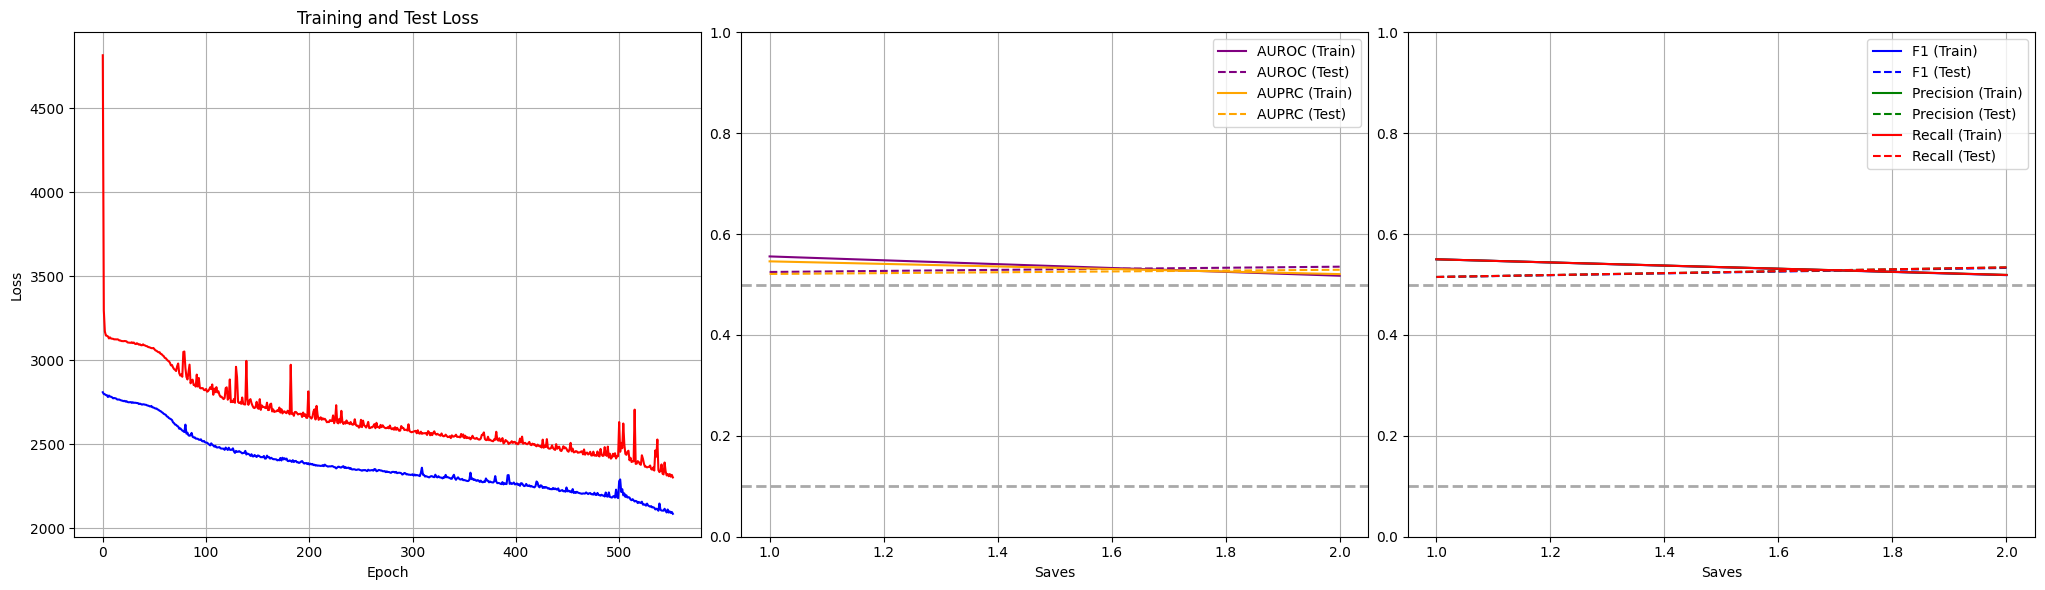

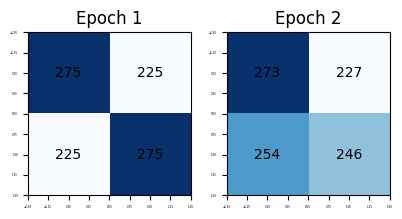

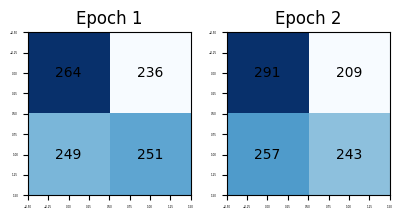

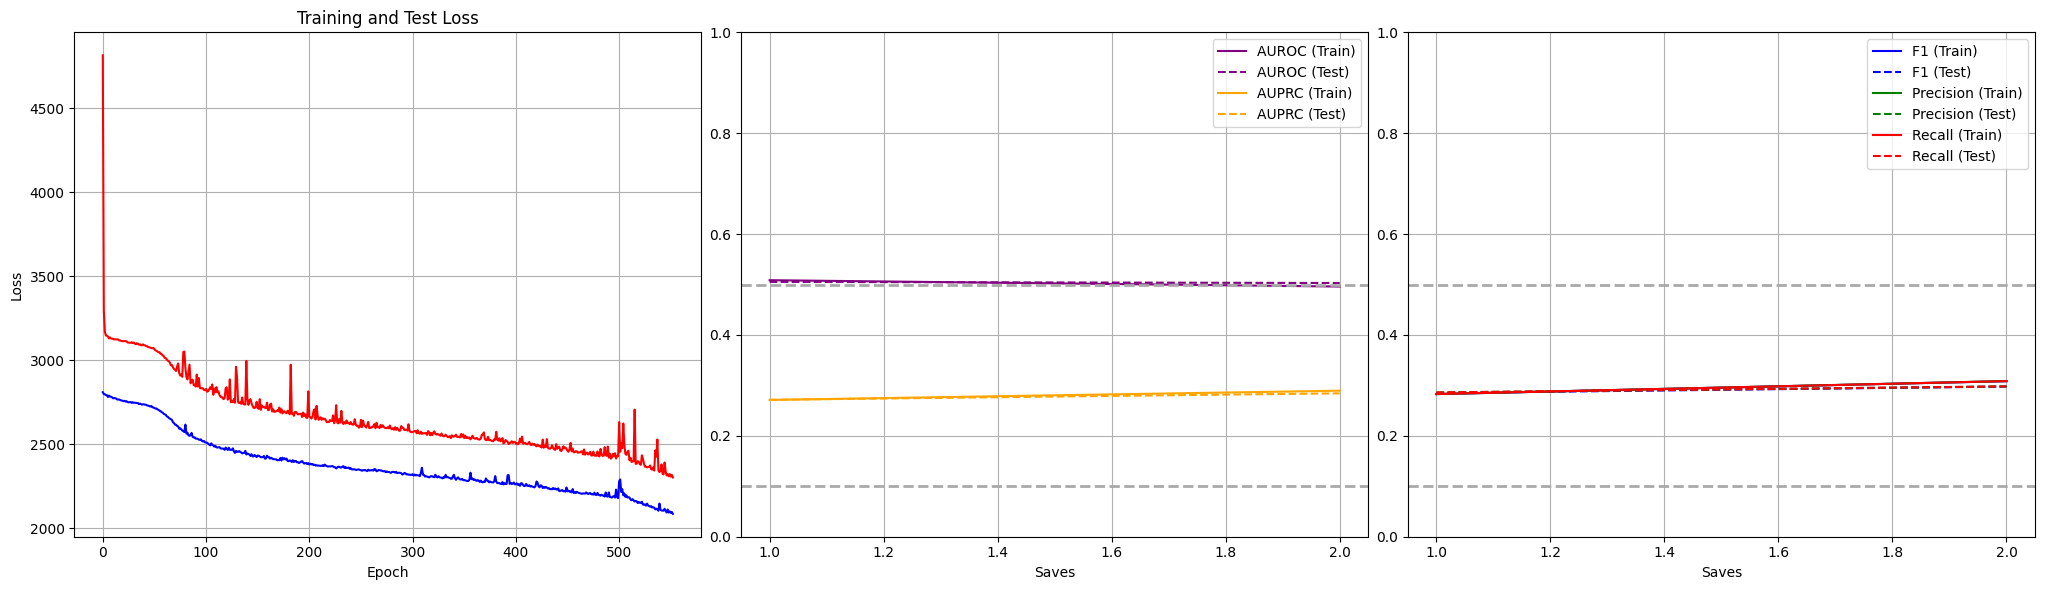

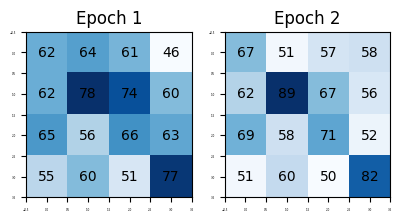

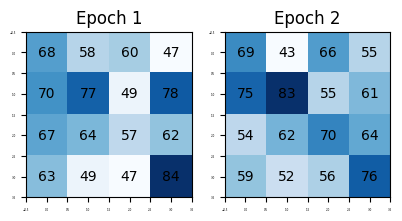

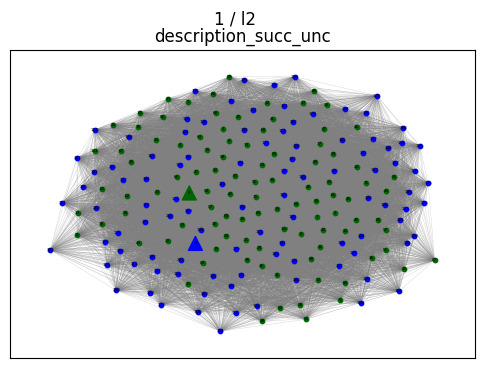

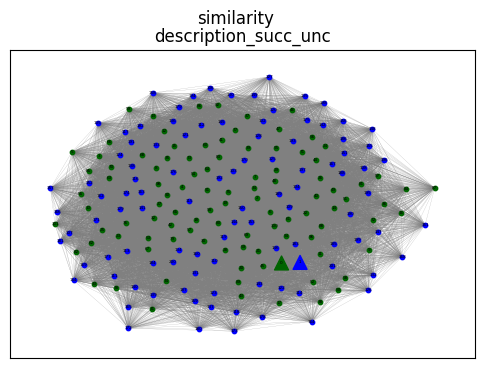

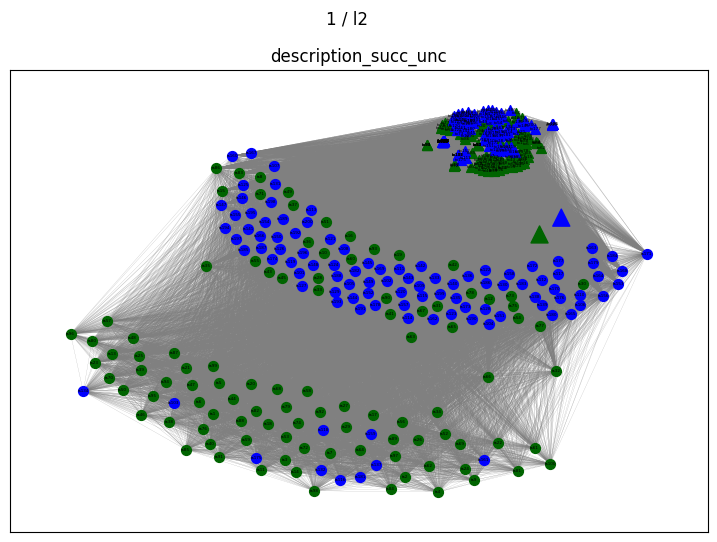

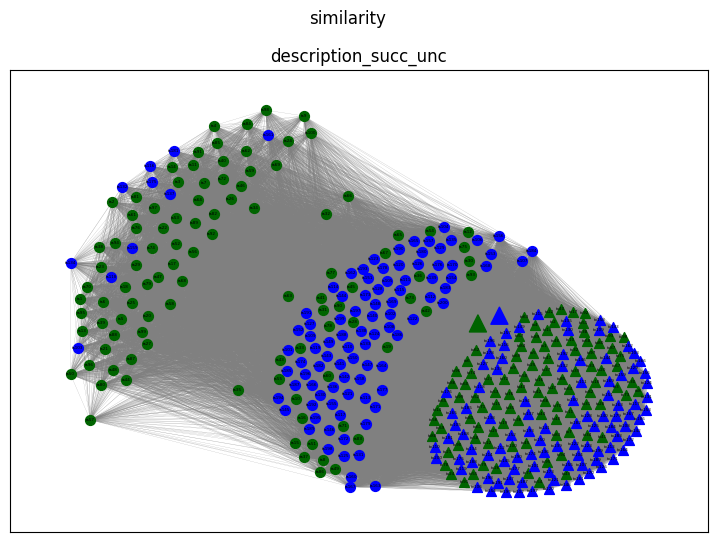

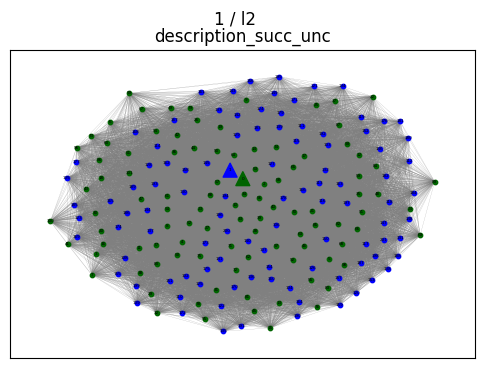

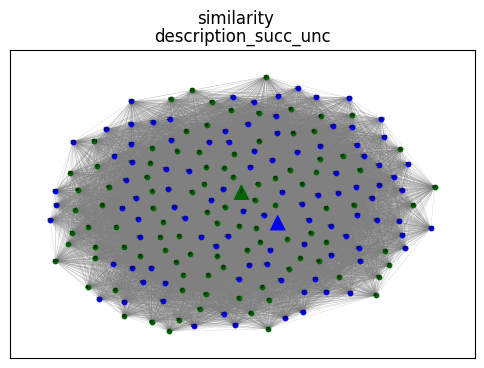

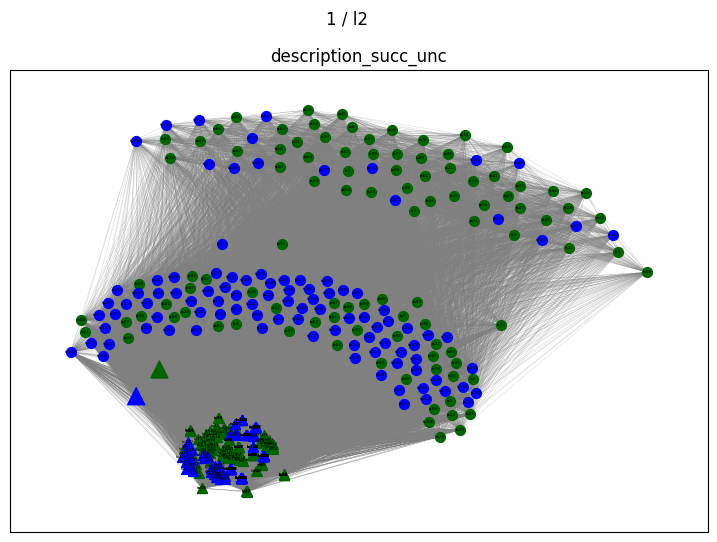

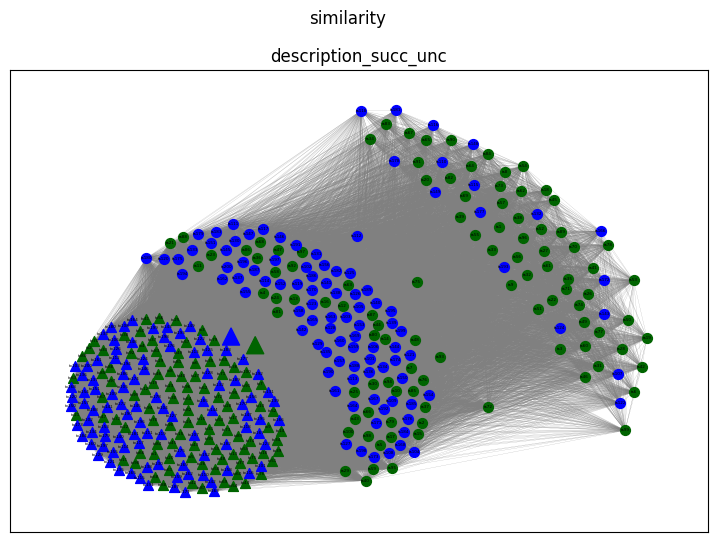

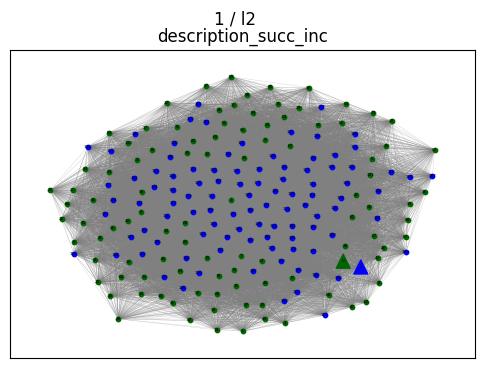

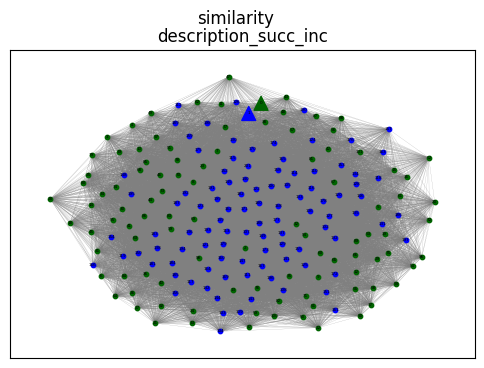

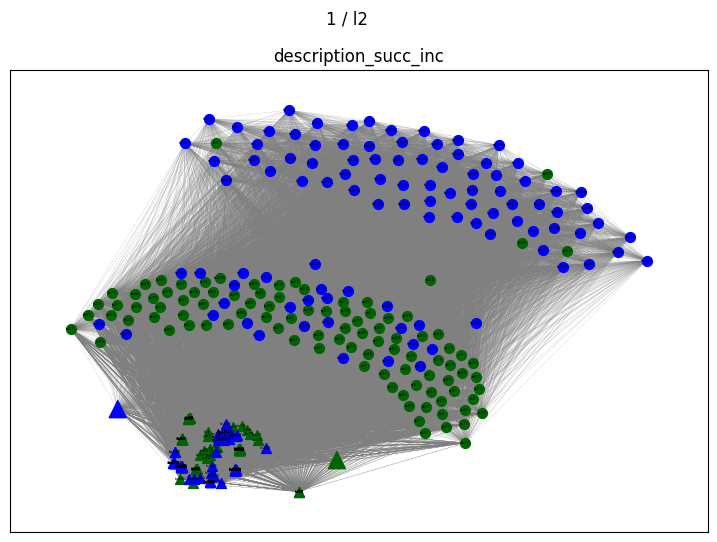

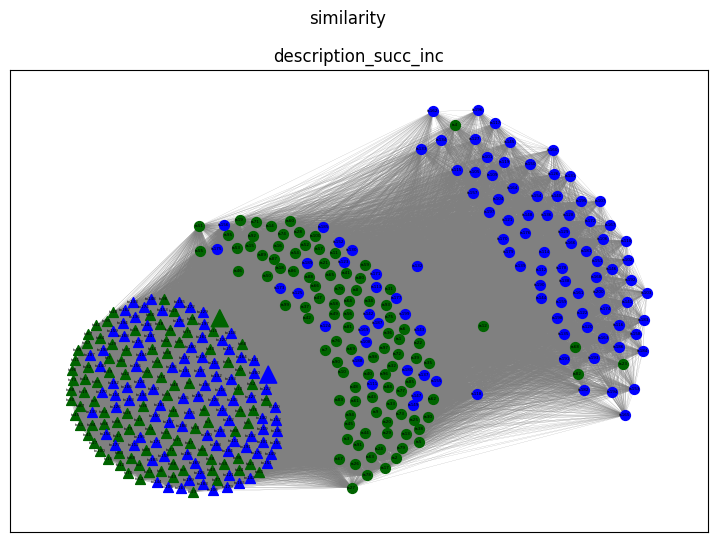

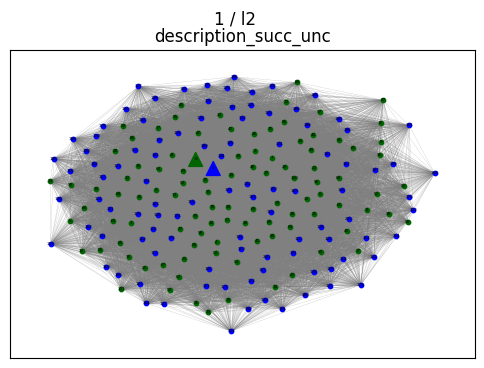

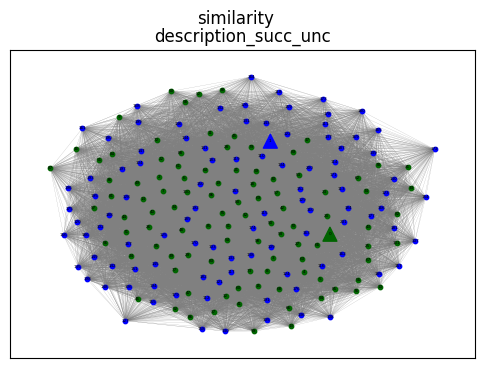

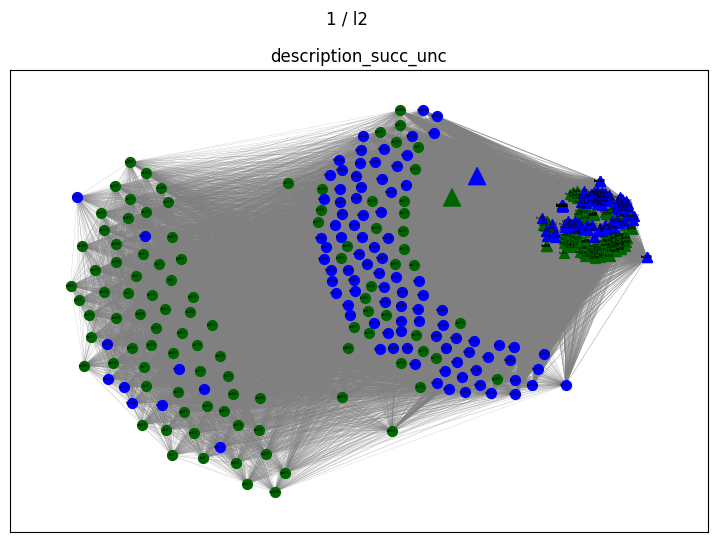

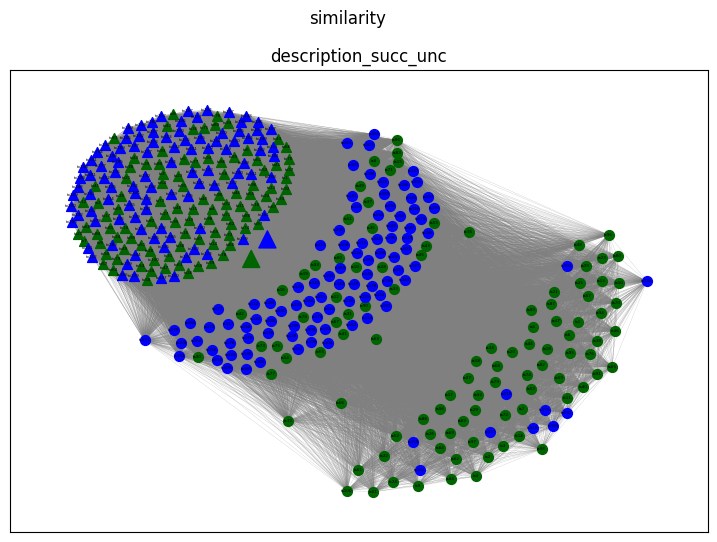

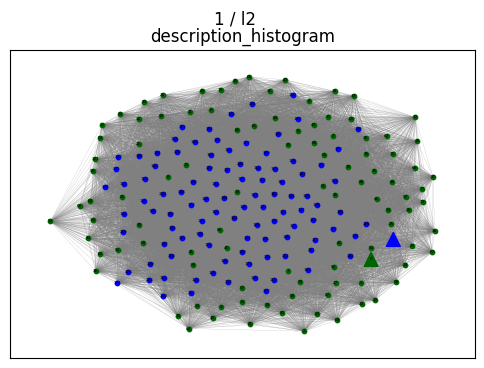

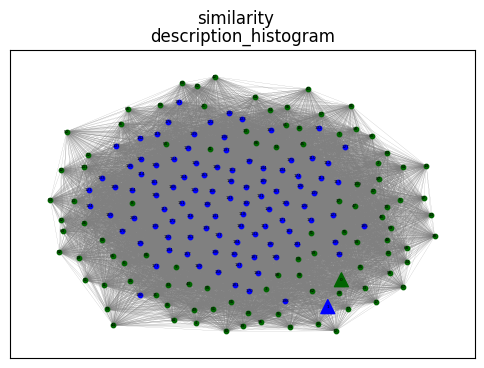

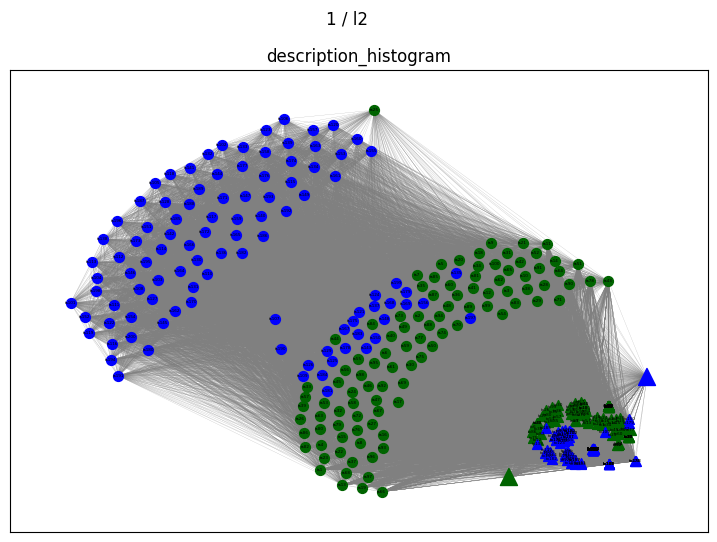

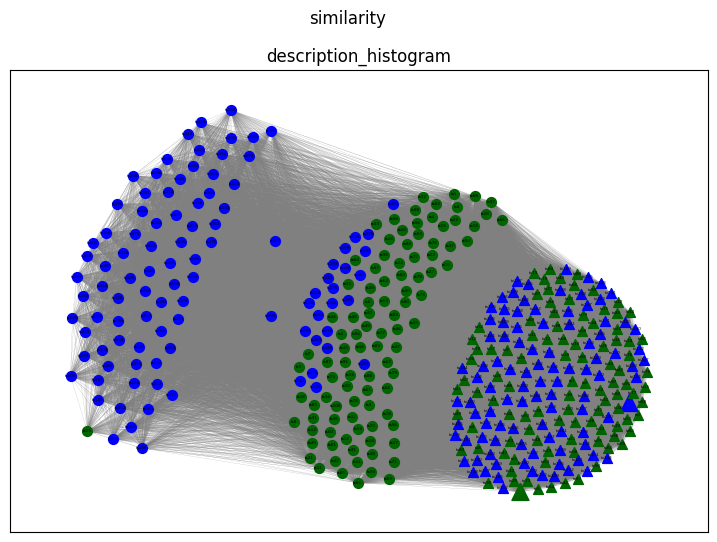

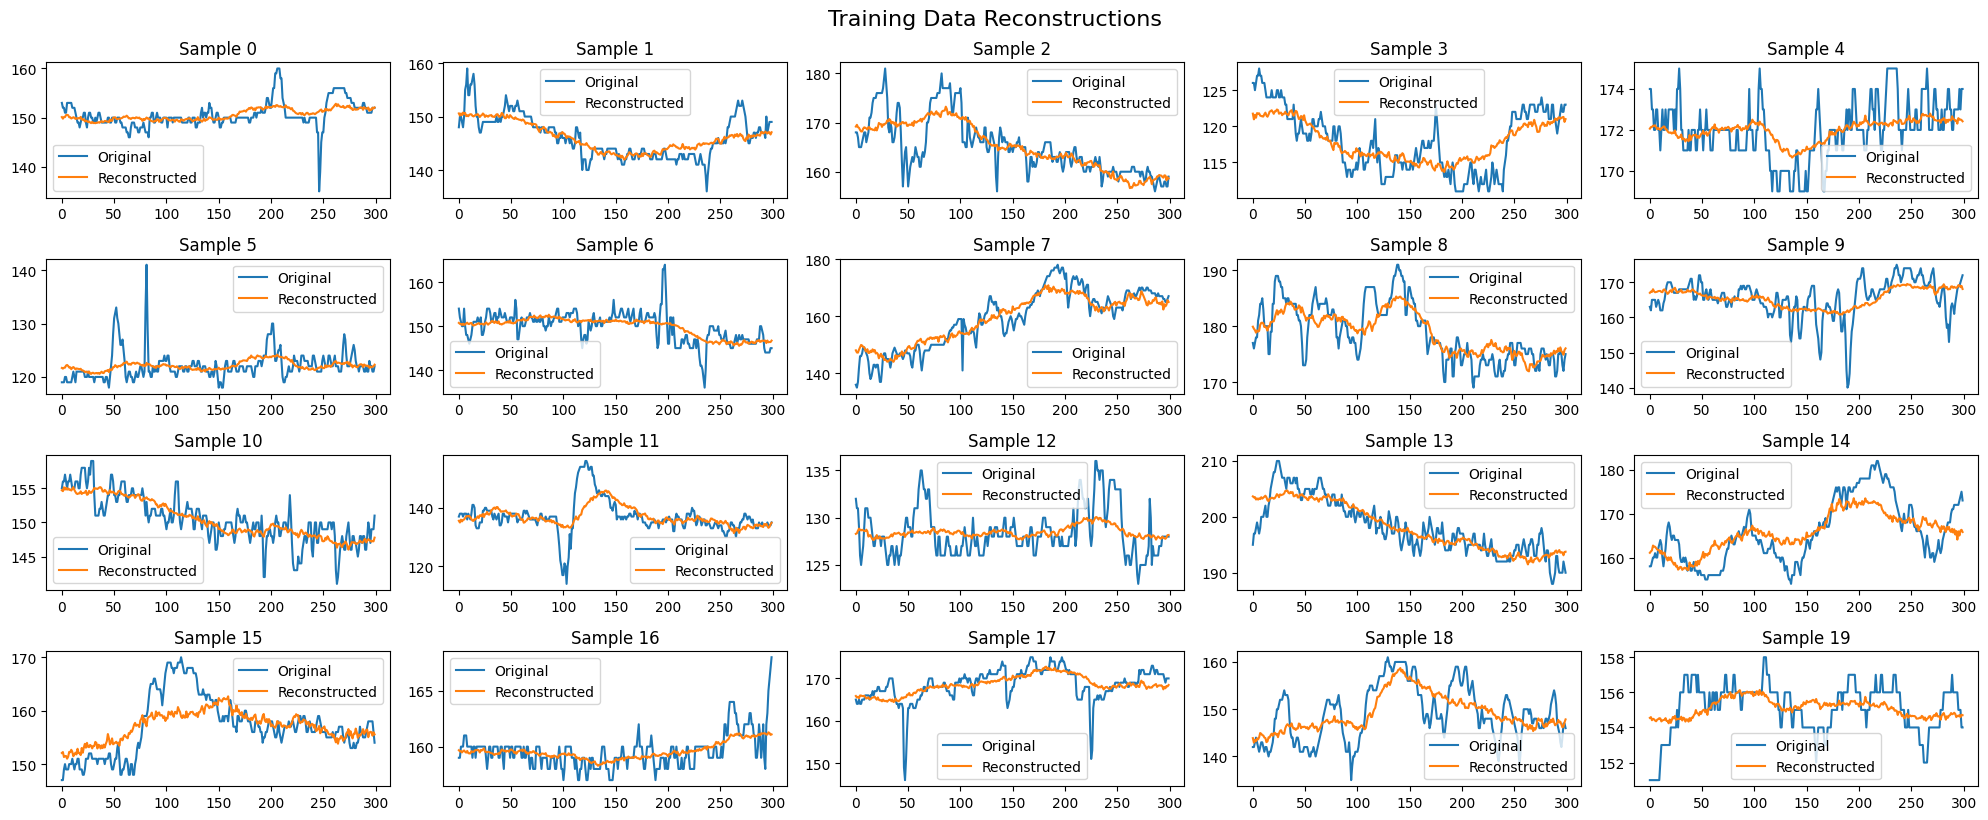

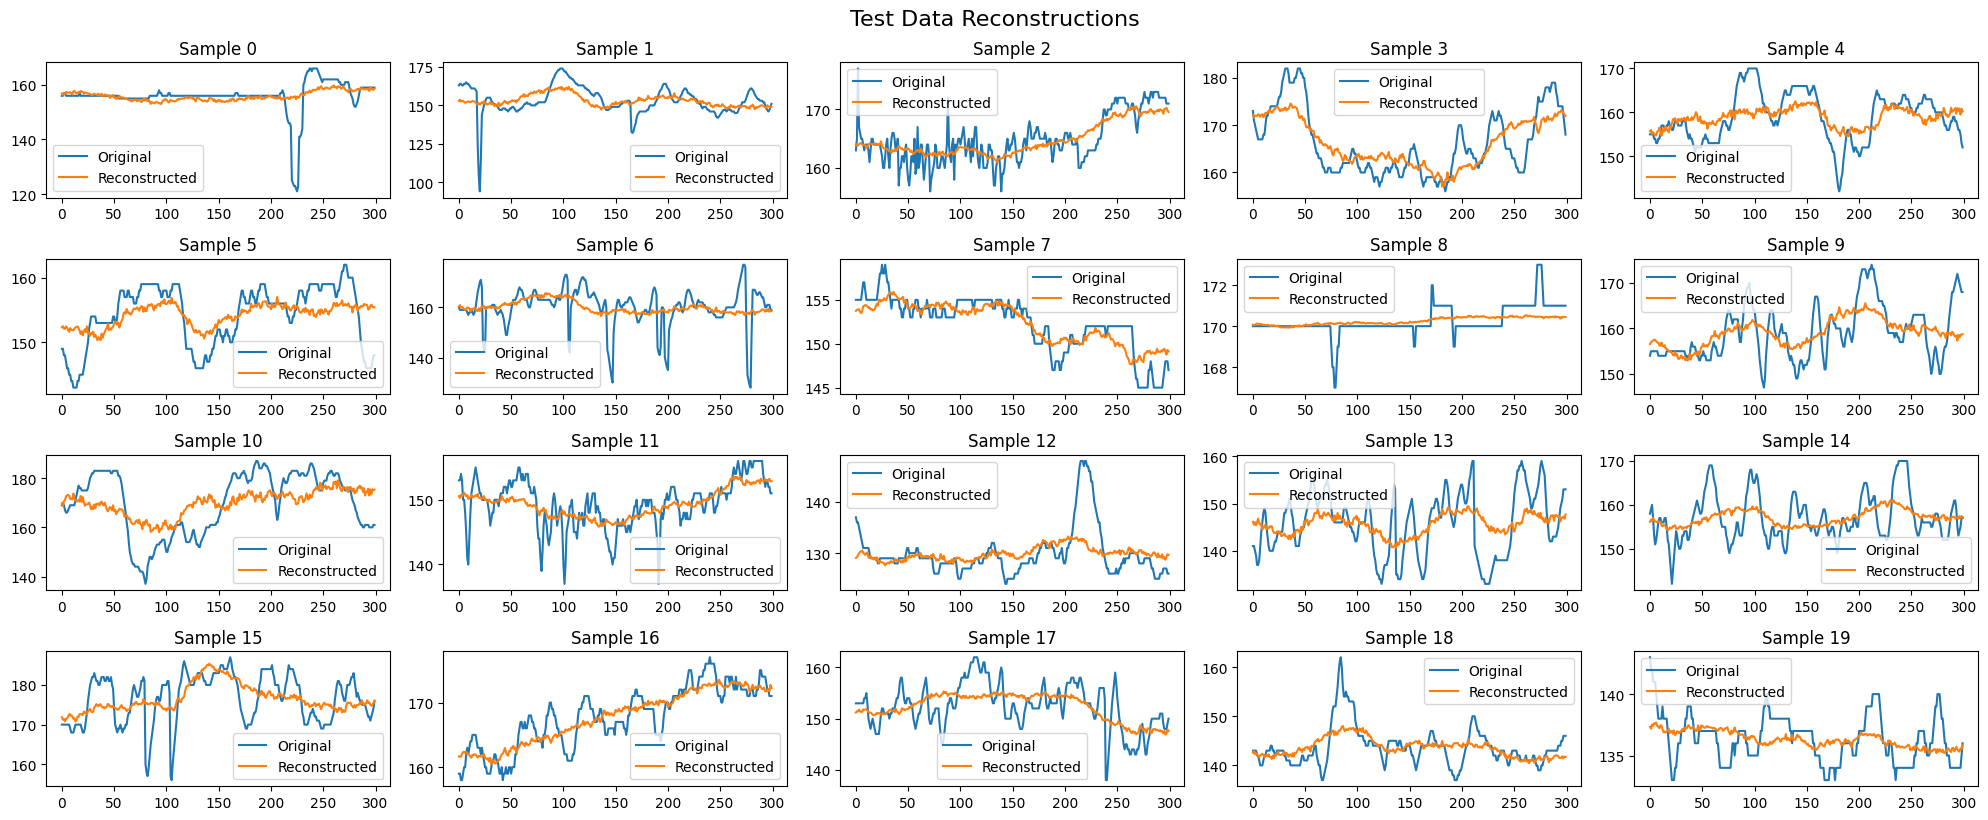

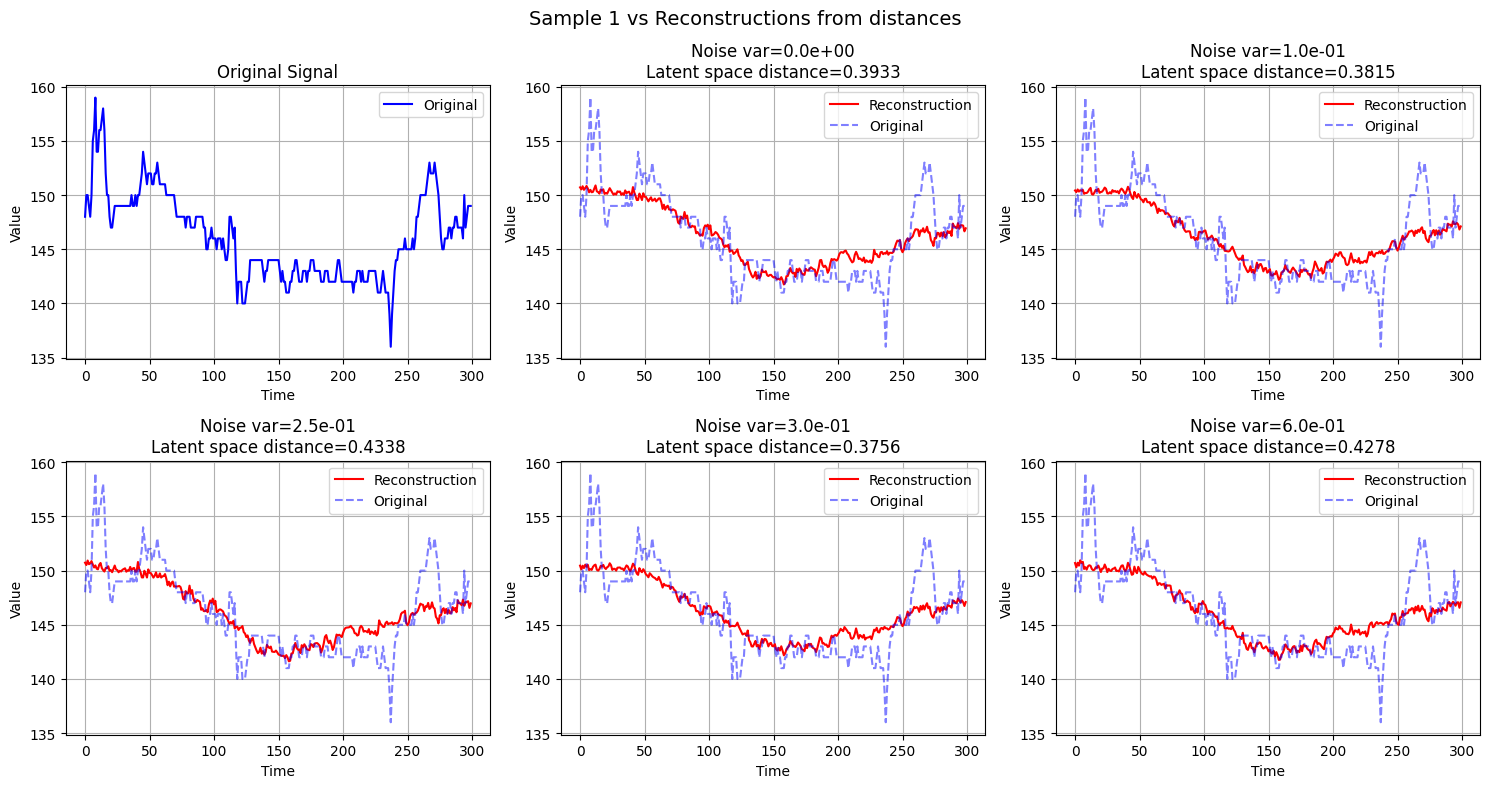

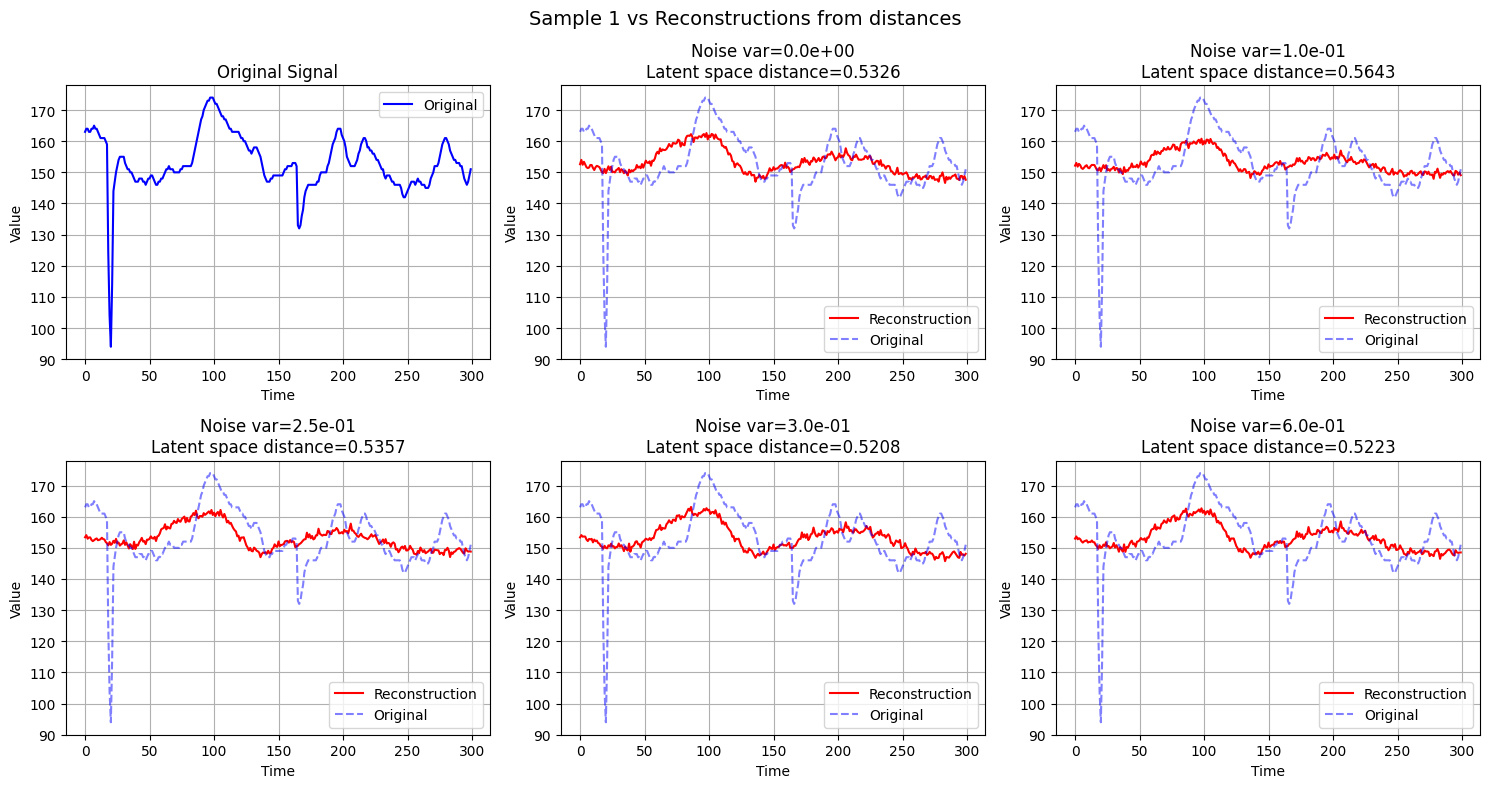

Epoch [1/500]
	Training Loss: 2078.326538 (clip: 830.814575, vae: 12475.119141)
	Testing Loss: 2306.625000 (clip: 860.566772, vae: 14460.580566)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [11/500]
	Training Loss: 2059.190491 (clip: 830.579102, vae: 12286.112793)
	Testing Loss: 2269.027588 (clip: 862.754791, vae: 14062.728027)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [21/500]
	Training Loss: 2036.696167 (clip: 830.518280, vae: 12061.778320)
	Testing Loss: 2246.572510 (clip: 863.099243, vae: 13834.731934)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [31/500]
	Training Loss: 2014.723755 (clip: 832.237183, vae: 11824.865234)
	Testing Loss: 2239.140747 (clip: 861.764862, vae: 13773.758789)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [41/500]
	Training Loss: 1999.058838 (clip: 832.399963, vae: 11666.588379)
	Testing Loss: 2213.275879 (clip: 860.097961, vae: 13531.778320)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [51/500]
	Training Loss: 1980.750000 (clip: 831.673981, vae: 11490.760254)


[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument



Training interrupted by user. Saving current progress...
----------------------------------------------------------------------
Metric     |  Training  |  Testing
----------------------------------------------------------------------
F1        |   0.473   |   0.510
Precision |   0.470   |   0.523
Recall    |   0.476   |   0.498
AUROC     |   0.470   |   0.509
AUPRC     |   0.484   |   0.509
----------------------------------------------------------------------
----------------------------------------------------------------------
Metric     |  Training  |  Testing
----------------------------------------------------------------------
F1        |   0.293   |   0.263
Precision |   0.293   |   0.264
Recall    |   0.293   |   0.264
AUROC     |   0.498   |   0.493
AUPRC     |   0.270   |   0.263
----------------------------------------------------------------------


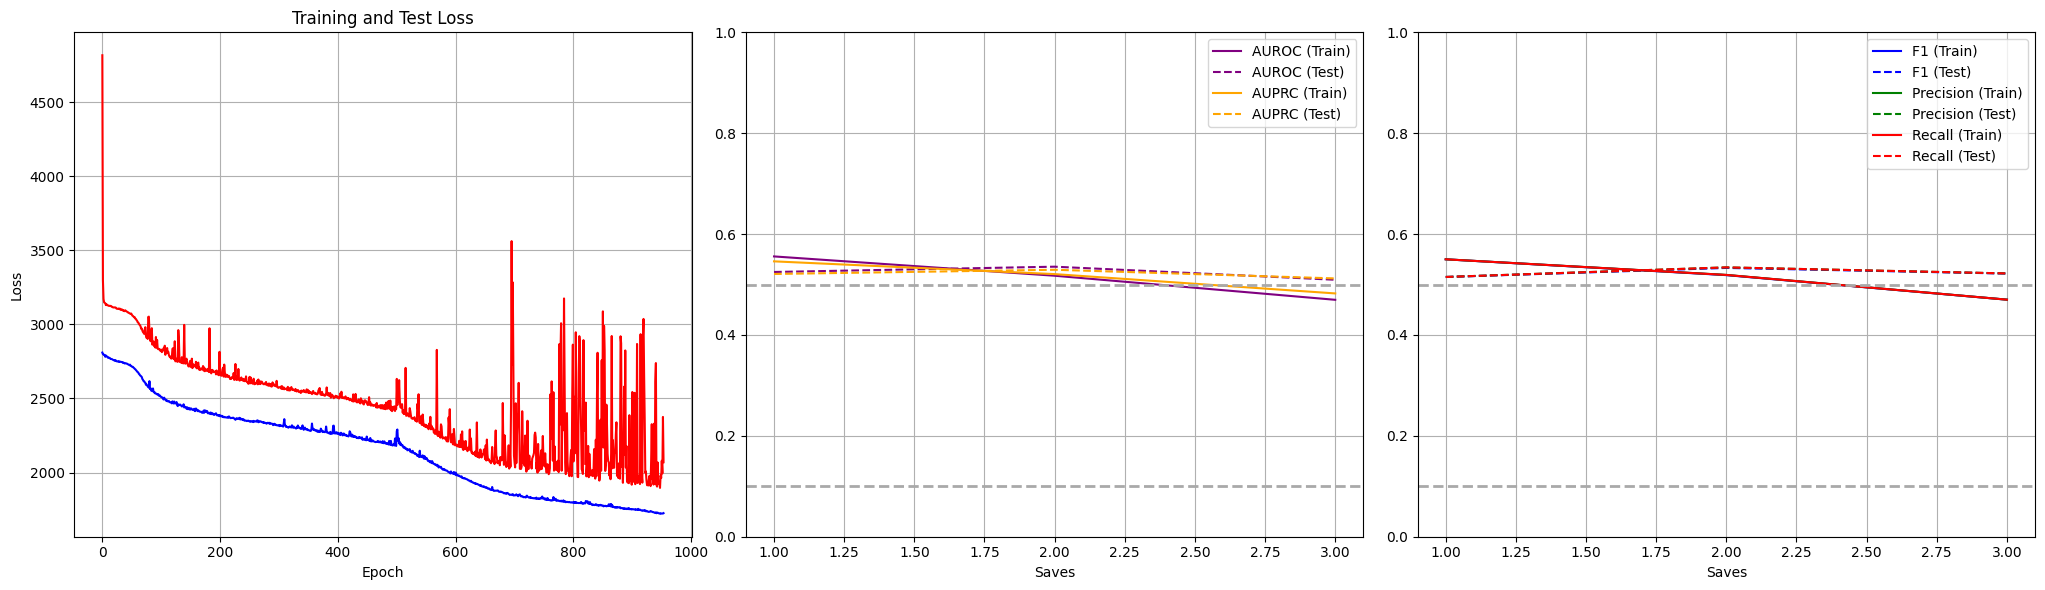

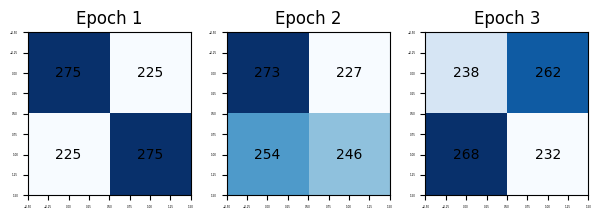

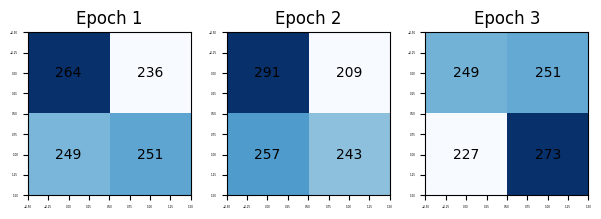

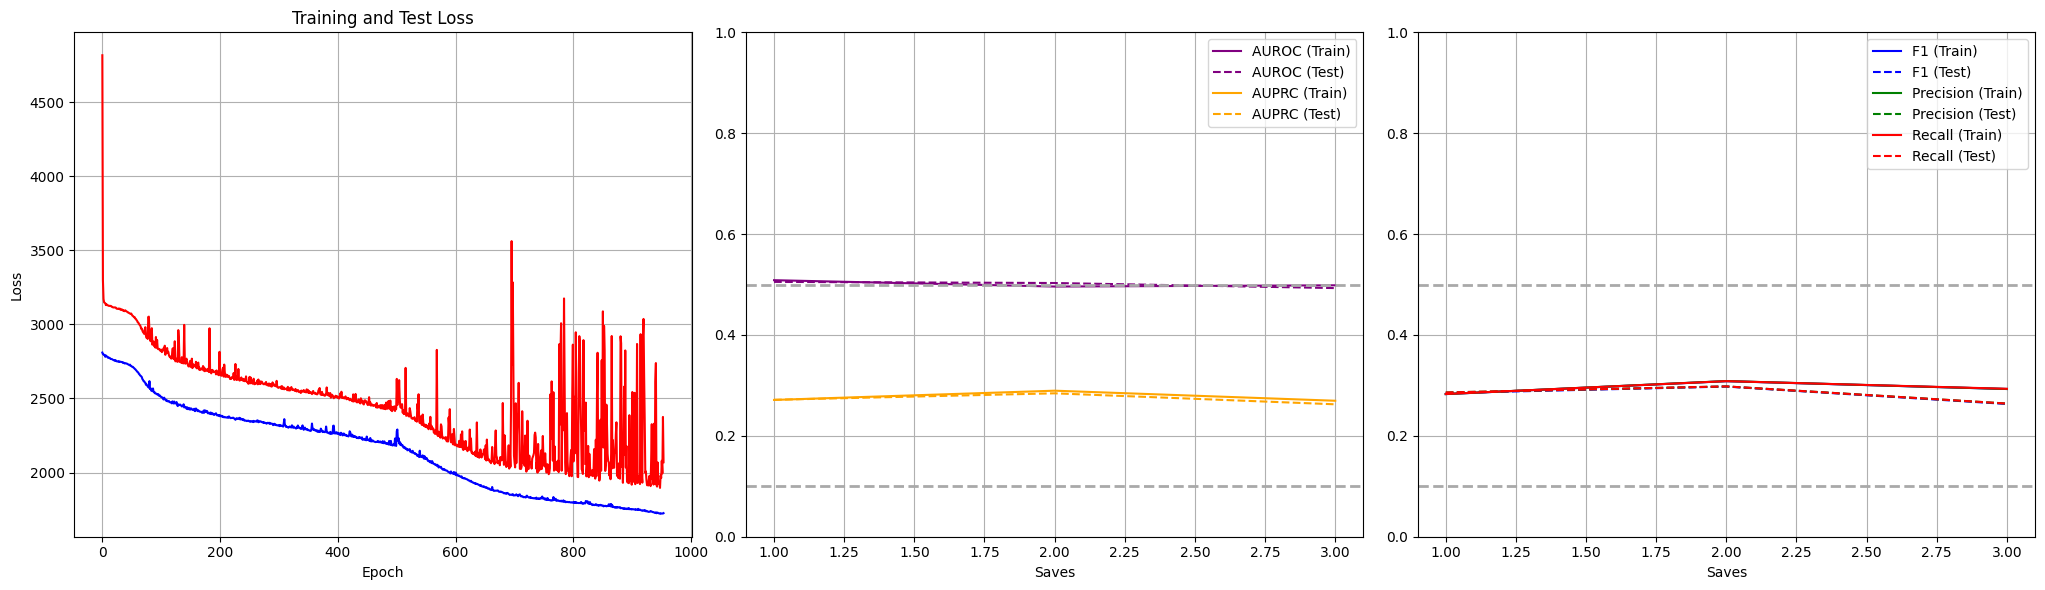

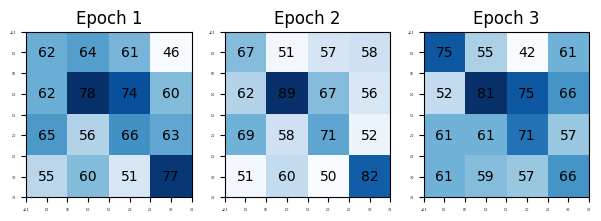

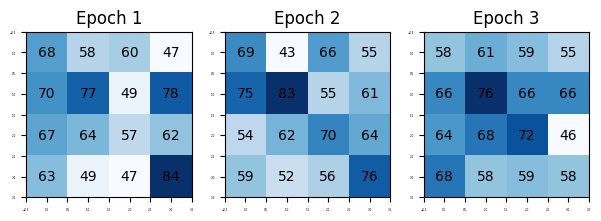

In [ ]:
# overwrite = False
with open('run_train.py', 'r') as file:
    exec(file.read())


# Diagnose

In [6]:
# pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
# for i in range(95, 105):
#     print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])
    
# for i in range(95, 105):
#     print(ts2tx_distances['l2']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['l2']['Low amount of consecutive increases.'][i])

# Generation

4    High amount of consecutive increases.
Name: text, dtype: object


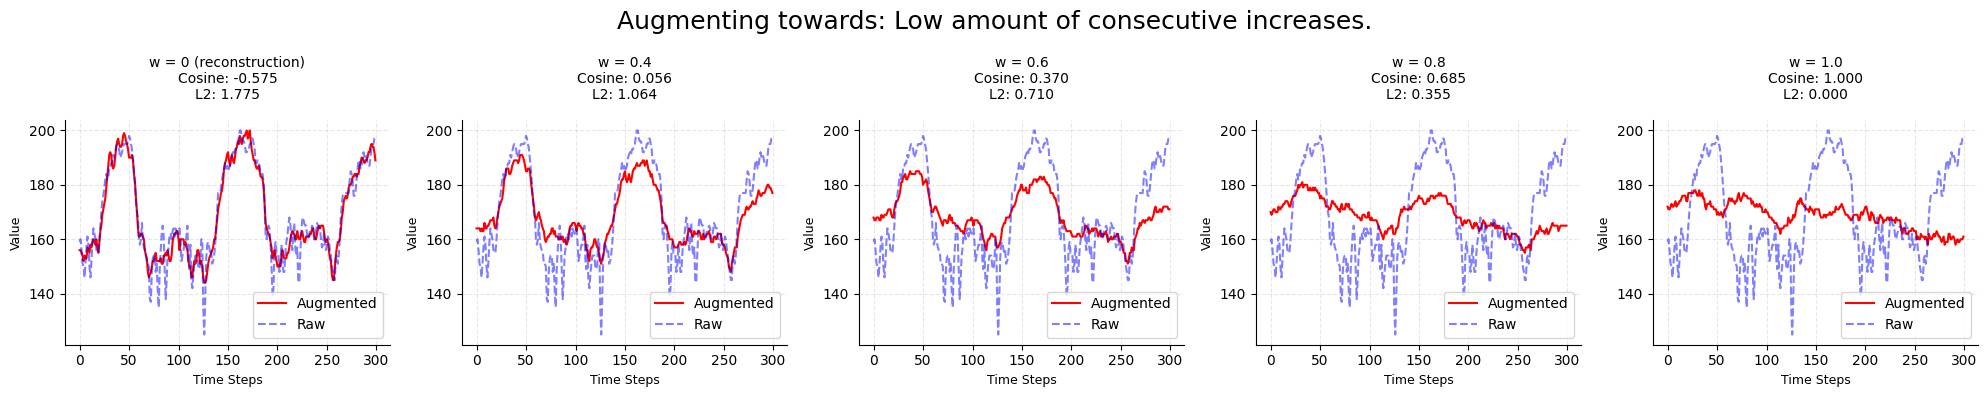

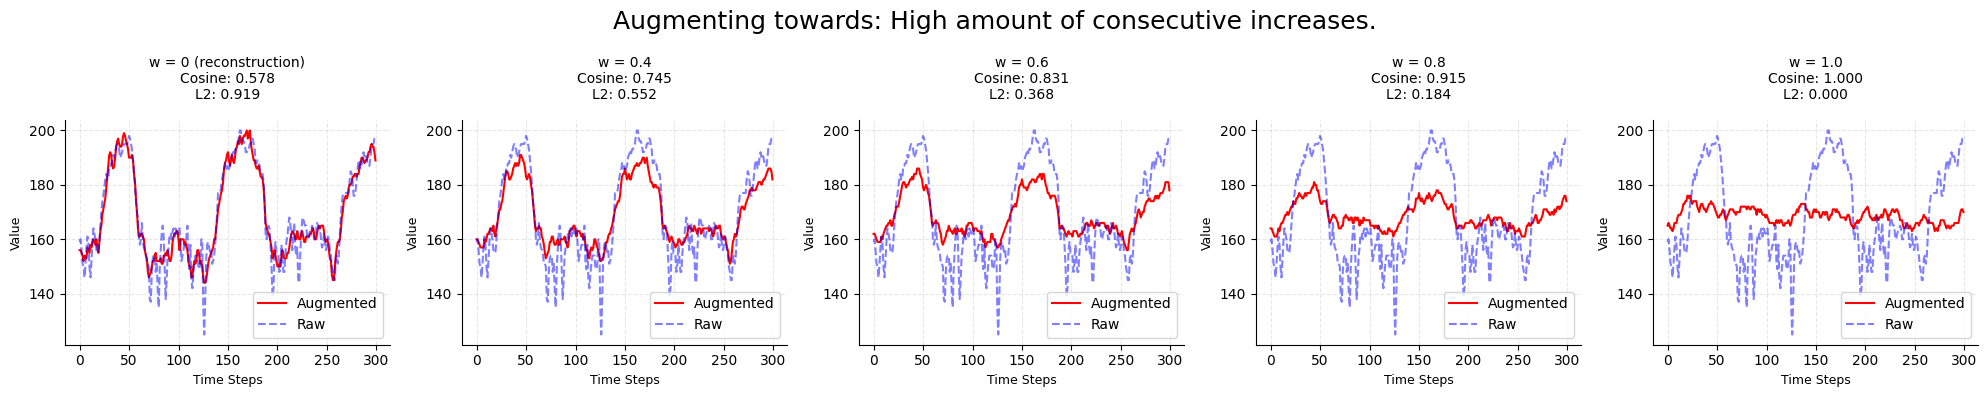

In [7]:
df_train0 = df_train[df_train[config_dict['y_col']] == config_dict['y_levels'][0]].reset_index(drop=True)
df_train1 = df_train[df_train[config_dict['y_col']] == config_dict['y_levels'][1]].reset_index(drop=True)
df_test0 = df_test[df_test[config_dict['y_col']] == config_dict['y_levels'][0]].reset_index(drop=True)
df_test1 = df_test[df_test[config_dict['y_col']] == config_dict['y_levels'][1]].reset_index(drop=True)

tid = 4
df = df_train0.iloc[[tid]].copy()
print(df['text'])
df['text1'] = 'Low amount of consecutive increases.'
df['text2'] = 'High amount of consecutive increases.'

text_cols = ['text1', 'text2']
w_values = np.arange(0.4, 1.2, 0.2)
w_values = np.concatenate([[0], w_values])
plot_interpolate_ts_tx_ws(df, model, config_dict, text_cols, w_values = w_values, label = True)